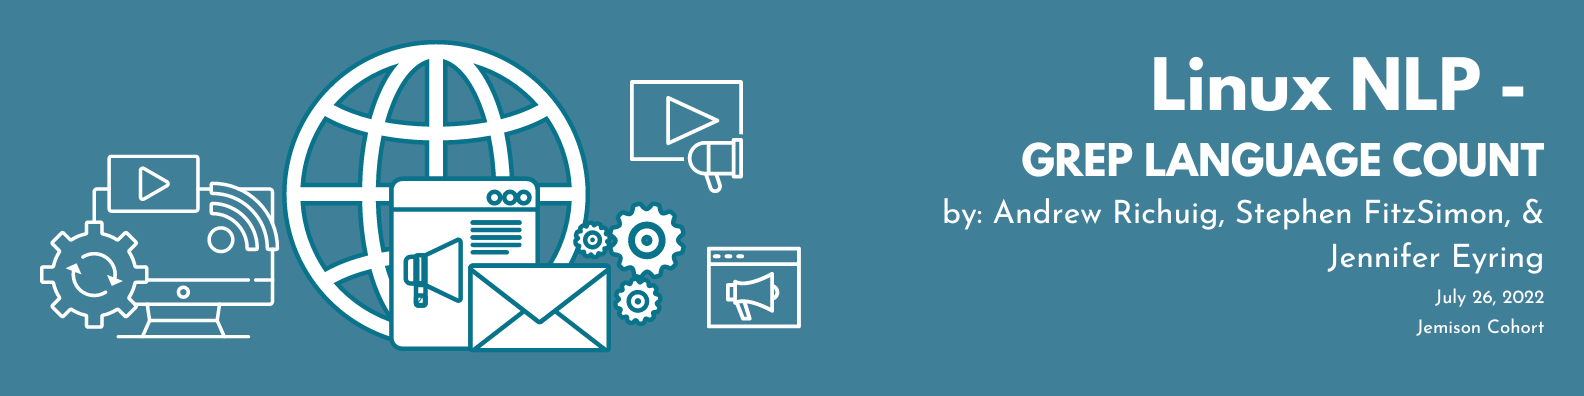

## PREDICTING PROGRAMMING LANGUAGE WITHIN LINUX README REPOS

by Andrew Rachuig, Stephen Fitzsimon and Jennifer Eyring

_______________________________

<b>Introduction Notes:</b> This NLP project is based on utilizing webscraping methods to create a predictive Classification Model.
<br>
<br>
Our team scraped the top 3,300 most-forked Linux Github repositories (as of July 20, 2022) to determine what are the top programming languages being used on Linux Github projects.
<br>
<br>
After finding the top languages being used for each Github repo, we then took the words/wording within the README sections of the repos to see if we could build a model that could predict what programming language was used; solely based on the README content and text.
<br>
<br>
### <b>Audience Notes about the Data:</b> 
The source of our data came from webscraping the top-forked Linux Github repositiories, by searching Linux and then also pulling the content of Linux's three common flavors: Arch, Debian and Ubuntu. You can read more of the step-by-step of how to replicate this repo in the README section.


__________________

## Initial Questions when starting this project:

Our initial questions and hypotheses were applied to the full corpus of all the Linux repos, as well as also thinking on micro-levels on what questions we could ask between the 3 flavors of Linux that was webscraped as well.

#### Full Corpus:
> - How many & what are the unique words to each specific programming language?<br><br>
> - Are there any bigrams/trigrams that are specific to certain programming languages?<br><br>
> - Do certain programming languages have larger README sections than others? And if so, which ones?<br><br>
#### Flavors of Linux (ie Archlinux, Debian and Ubuntu:
> - With Linux-flavors-Debian, Arch and Ubuntu-are there differences in README lengths? (ie does one flavor over the others seem to have more details needed or explained than others?)<br><br>
> - Are there differences in words/phrases to Linux-flavors- specifically Ubuntu, Debian and Archlinux.<br><br>

__________________________

# Project Goals:

> - Utilize Codeup's webscraping function and apply it to our project's parameters of obtaining the top-forked Linux repositories.<br><br>
> - To determine any commonalities/differences between programming languages and the README sections of the repositories.<br><br>
> - Create a classification model that can predict what programming language is used, solely based on the README content/words.

# Executive Summary:

___________________________________________

<h1>ABOUT THE DATA:</h1>

Our team collected 3,300 top-forked Github repos that were specific flavors of Linux: Archlinux, Ubuntu, and Debian repositiores. Each flavor we pulled 1,100 and then combined these webscraped repositories into one large dataframe.

### Key notes:
- 3,300 repositories were collected.
- 2,805 were used in this model, after clean/normalizing data.
- <b>Top 3 programming languages used in all the repos:
    - 1) Shell
    - 2) Python
    - 3) C<br></b>
    
<u>Breaking things down into the three different flavors of Linux:</u><br>
    - Archlinux: 1,100 repositories were collected
                _______ were used once cleaned<br>
    - Debian: 1,100 respositories were collected
                _______were used once cleaned<br>
    - Ubuntu: 1,100 respositories were collected
                _______were used once cleaned


<div class="alert alert-info">
Size of data:<br>
<b>Pre-Clean/Normalize: 3,300 rows | 3 columns<br>

<b>After cleaning & normalizing: 2,805 rows | 6 columns
</div>

## Wrangle Process:

#### Measures taken to clean and normalize the data:

> 1) We dropped all nulls as these related to repos that had no languages defined.<br><br>
> 2) Using NLTK tools, we replaced any abnormal symbols and https-related phrases with single spaces on the readme_contents column.<br><br>
> 3) We tokenized the dataset on this same column.<br><br>
> 4) After cleaning/normalizing, we had used the proportions of most common words throughout the repos across every programming language to determine which words need to be removed as they took away from the information the corpus was provided on predictability.<br><br>
> 5) We lowered all capitilizations within the readme content.<br><br>
> 6) And finally we stemmed all words so keep key words/phrases similar.<br><br>
> 7) We added the following columns:
- `disto` : to label which repos were Arch, Ubuntu or Debian
- `clean_readme` : to have a comparison of the original collected text `readme_contents`
- `length_readme`: counts how many unique words are in each repo.
- `readme_string`: that takes the clean_readme and applies as strings rather than list.

______________________

## Exploring the main dataset:

#### Calling in the data:

In [57]:
#imports:

#tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np

#group imports
import env
import acquire
import constants_prepare as c
import explore

import json
from typing import Dict, List, Optional, Union, cast
import requests
import nltk

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#hypothesis testing
import scipy.stats as stats

#modeling tools
from sklearn.metrics import classification_report, accuracy_score
import modeling as m

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")


In [64]:
#calling in master_df:
master_df = pd.read_json('master_df.json')
master_df.head(5)

,repo,language,readme_contents,distro,clean_readme,length_of_readme,readme_string
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,ubuntu,"[dockerfil, repositori, contain, dockerfil, ba...",21,"dockerfil,repositori,contain,dockerfil,base,do..."
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,ubuntu,"[packer, templat, written, legaci, json, overv...",382,"packer,templat,written,legaci,json,overview,re..."
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,ubuntu,"[deepin, wine, deepinwin, ubuntudebian, deepin...",153,"deepin,wine,deepinwin,ubuntudebian,deepin,gite..."
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,ubuntu,"[dockerubuntuvncdesktop, docker, pull, docker,...",335,"dockerubuntuvncdesktop,docker,pull,docker,star..."
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,ubuntu,"[docker, i386, buildimagesh, docker, 32bitubun...",7,"docker,i386,buildimagesh,docker,32bitubuntu160..."


### TOP 10 COMMON LANGUAGES USED IN FULL CORPUS:

In [3]:
explore.top_common_languages(master_df)

GridspecLayout(children=(Output(layout=Layout(border='1px solid black', grid_area='widget001')), Output(layout…

___________________________________

## Average length of Repositories:
#### Key takeaways:
- <mark>Our initial question of : <i>Do certain programming languages have larger README sections than others? And if so, which ones?</i> is answered here.
    - Surprisingly the length of respositories based on language count does not reflect the most common languages used. 
    - It does make sense that Jupyter Notebook would have the longest README length, as these were pulled from Github.
    - However, it is surprising to see that none of the top most used languages are not even within the top 3 for average repo length.

In [66]:
master_df.length_of_readme.describe()

count     2805.000000
mean       279.625312
std        638.081673
min          0.000000
25%         47.000000
50%        124.000000
75%        283.000000
max      15538.000000
Name: length_of_readme, dtype: float64

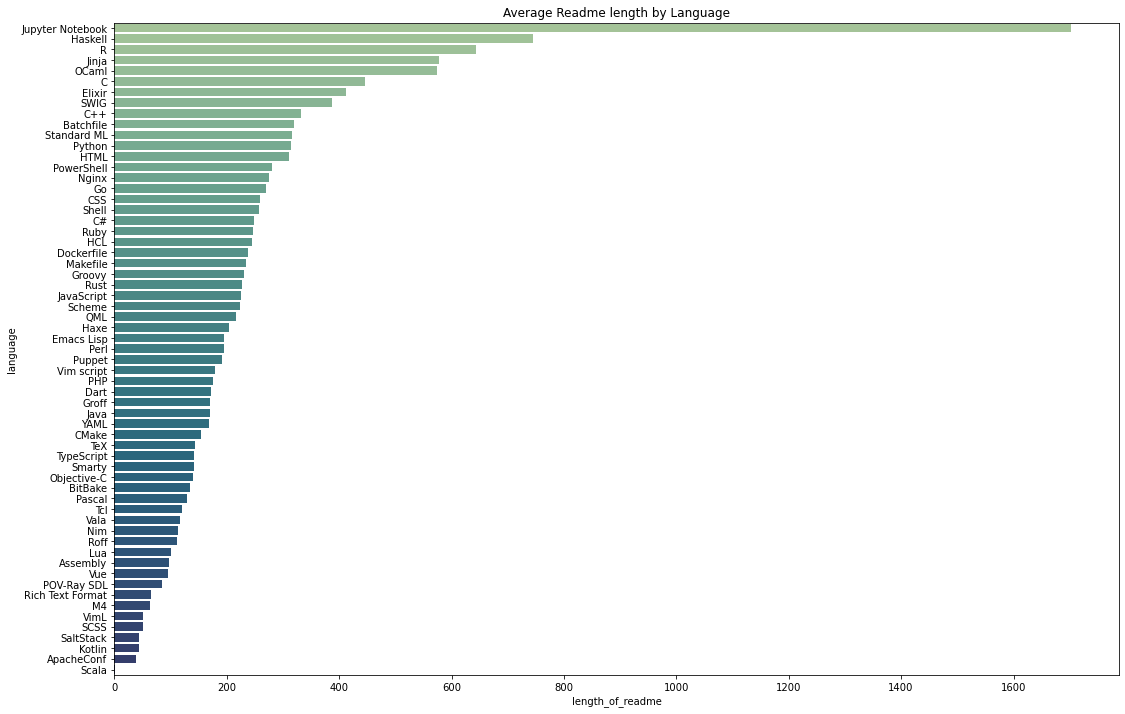

In [4]:
explore.readme_avg_length(master_df)

_____________________________________

## Number of Unique Words in Corpus:

#### Key takeaways:
- <mark><b>There are 85,825 unique stemmed words in the overall corpus.</b>
    - Top 10 words of full corpus include: version,kernel,docker, updat,bash,server,1,command,support,follow  
    - Even after adding in common stopwords based on dropping common words that had a differnece in frequency of less than 1%, we still are seeing common stopwords that each language shares.
            -EX: The top 5 most common words in Shell, Python and C each include 'version', and at least two lanugages share: 'updat', 'support', and 'kernel'

In [6]:
linux_corpus = explore.linux_corpus(master_df)

In [7]:
#taking a look at Corpus words:
linux_corpus.describe()

count      784349
unique      85825
top       version
freq         4149
dtype: object

In [8]:
linux_corpus.value_counts().nlargest(20)

version      4149
kernel       3731
docker       3671
updat        3600
bash         3508
server       3479
1            3455
command      3356
support      3340
follow       3058
contain      3025
name         2757
work         2704
chang        2647
directori    2620
2            2575
see          2523
add          2520
also         2504
start        2428
dtype: int64

### Top 20 Bigrams of Linux Corpus:

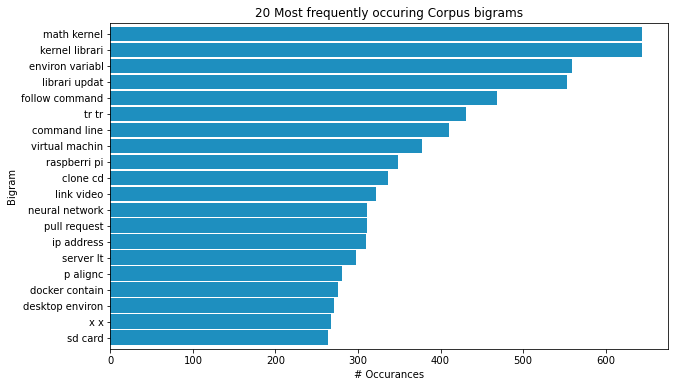

In [9]:
explore.top_20_linux_bigrams(linux_corpus)

### Top 20 Trigrams of Linux Corpus:

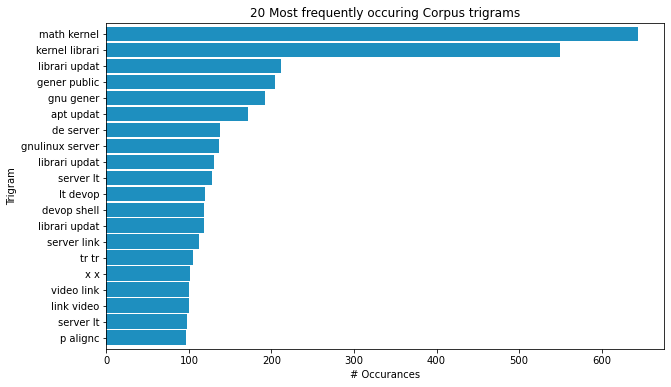

In [10]:
explore.top_20_linux_trigrams(linux_corpus)


### Word Cloud of full Linux Corpus:

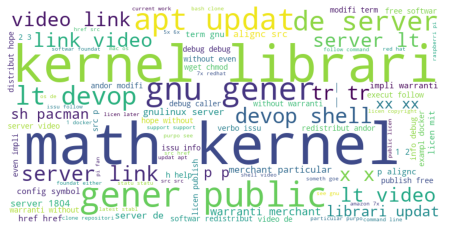

In [11]:
explore.linux_corpus__trigram_wordcloud(linux_corpus)

### Top Words & Bigrams found in Shell:

In [13]:
shell_corpus = explore.shell_corpus(master_df)

In [14]:
#taking a look at Shell words:
shell_corpus.describe()

count     412693
unique     48713
top         bash
freq        2445
dtype: object

In [15]:
shell_corpus.value_counts().nlargest(20)

bash         2445
updat        2350
server       2264
kernel       2247
version      2081
1            2048
docker       2011
e            1901
follow       1776
command      1744
support      1672
work         1574
contain      1542
2            1540
de           1522
add          1485
boot         1448
start        1418
chang        1363
directori    1339
dtype: int64

#### Top Bigrams found in Shell:

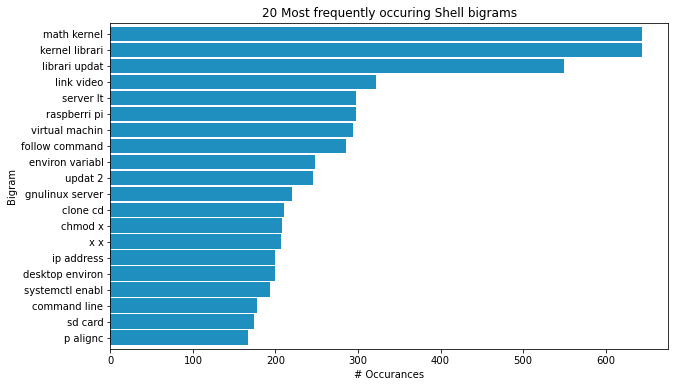

In [16]:
explore.top_20_shell_bigrams(shell_corpus)

### Top Words & Bigrams found in Python:

In [17]:
python_corpus = explore.python_corpus(master_df)

In [18]:
python_corpus.value_counts().nlargest(10)

python      631
version     591
support     547
command     486
updat       449
download    439
name        410
see         404
want        379
zabbix      376
dtype: int64

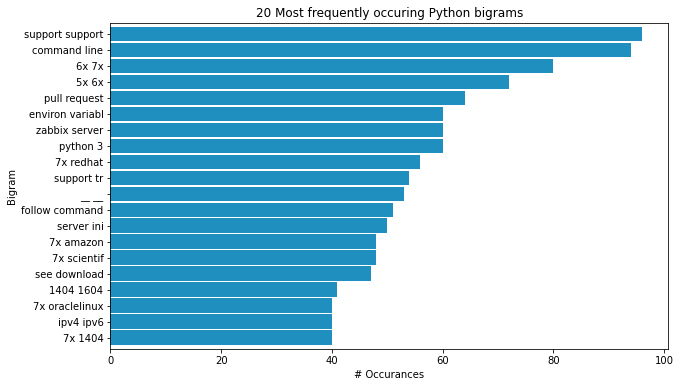

In [19]:
#top bigrams of Python language in Linux repos:
explore.top_20_python_bigrams(python_corpus)

### Top Words and Bigrams found in C:

In [35]:
C_words = master_df[master_df.language == 'C'].clean_readme.reset_index()

In [36]:
C_corpus = []
for i in range(len(C_words)):
    C_corpus.extend(C_words.clean_readme[i])
C_corpus

['deepin',
 'wine',
 'deepinwin',
 'ubuntudebian',
 'deepin',
 'giteegithubgit',
 'gpl1726509538qqcom',
 'ubuntudebian',
 '21819',
 '1',
 'bug',
 'relea',
 'bash',
 'wget',
 'qo',
 'ubuntudebian',
 'clone',
 'clone',
 'releasesgithub',
 'gite',
 'installsh',
 'kdex',
 'kdeinstallsh',
 'deepinwine21822ubuntu',
 'install_2822sh',
 '2',
 'deepinwin',
 'dpkg',
 'deepin',
 '1',
 'qq',
 '2',
 'tim',
 '3',
 'qq',
 '4',
 '5',
 'foxmail',
 '6',
 '7',
 '360',
 '8',
 'winrar',
 '9',
 '10',
 'deepinwin',
 '1',
 'qq',
 '2',
 'tim',
 '3',
 'qq',
 '4',
 '5',
 'foxmail',
 '6',
 '7',
 '360',
 '8',
 'winrar',
 '9',
 '1kdekd',
 'neonkubuntu',
 '180418011802kde',
 '2',
 '3',
 '1804',
 'gnome',
 'gnome',
 'shell',
 'topicon',
 'plu',
 '4tim',
 'flash',
 '1',
 'install_flash_player_ppapiex',
 '2',
 'deepinwinedeepintimdrive_c',
 'tim',
 'wine',
 'c',
 '3',
 'termin',
 'wineprefixdeepinwinedeepintim',
 'deepinwin',
 'cinstall_flash_player_ppapiex',
 'tim',
 '5winecfg',
 'wineprefixdeepinwin',
 'deepinwin',
 

In [20]:
#creating a series variable:
C_corpus = explore.C_corpus(master_df)

In [21]:
C_corpus.value_counts().nlargest(10)

kernel      1146
support      395
defin        381
version      350
address      340
function     335
command      317
devic        309
compil       299
also         286
dtype: int64

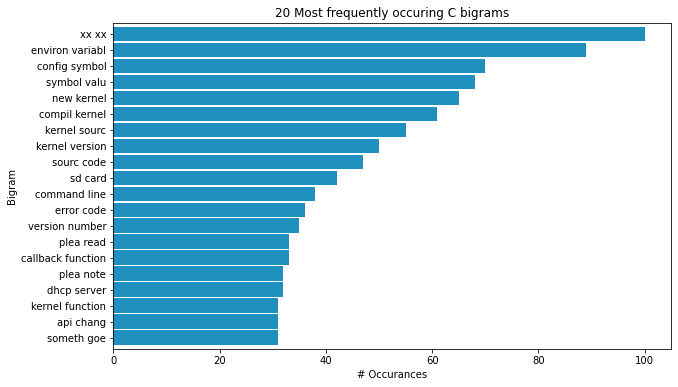

In [22]:
#top bigrams of C language in Linux repos:
explore.top_20_C_bigrams(C_corpus)

## Finding word frequencies per language:

In [42]:
shell_words

,index,clean_readme
0,0,"[dockerfil, repositori, contain, dockerfil, ba..."
1,1,"[packer, templat, written, legaci, json, overv..."
2,4,"[docker, i386, buildimagesh, docker, 32bitubun..."
3,6,"[termuxubuntu, chroot, termux, wget, proot, te..."
4,8,"[auto, server, shadowsockssh, auto, shadowsock..."
...,...,...
1593,3287,"[dd, daili, driver, desktop, config, wm, frien..."
1594,3289,"[majest, dotfil, dotfil, uso, clone, pacman, c..."
1595,3292,"[6, pkgbuild, revi, heavili, comment, version,..."
1596,3296,"[tial, twitch]"


In [43]:
#combining frequencies into dataframes:
word_counts = (pd.concat([shell_freq, python_freq,C_freq], axis=1, sort=True)
              .set_axis(['shell','python','C'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

NameError: name 'shell_freq' is not defined

____________________________________________________

### Overall Takeaways:

<b>Some of our initial questions were answered within this exploration of unique words.

Such as:<br>
    -"How many & what are the unique words to each specific programming language?"<br>
    - "Are there any bigrams/trigrams that are specific to certain programming languages?"

We found what that not only were their unique words (and bigrams/trigram) to each programming language but also even when putting contingencies on our stopwords lists, the languages also shared common words as well. 
    
This is good news as we get ready to build a predictive model on these unique words to help identify programming languages within the README contents.

_______________________________________

## Exploring data by Linux Flavors:

One interesting thing we have found is that by using three different flavors of Linux when webscraping the data, there were more unique additions to the dataset to help with building a predictive model.

### Key Takeaways:
...
...
...


### A snapshot of Archlinux

In [23]:
#calling in df
arch_df = explore.arch_subset()

### The most common languages for readme files in Archlinux:

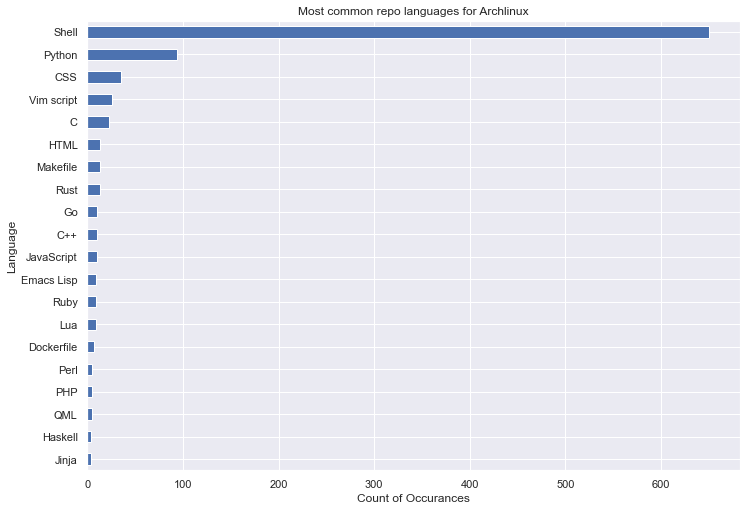

In [26]:
explore.arch_langs(arch_df)

In [28]:
arch_corpus = explore.arch_corpus(arch_df)

count     198917
unique     25821
top       pacman
freq        1268
dtype: object

### Top 10 unique words for Archlinux:

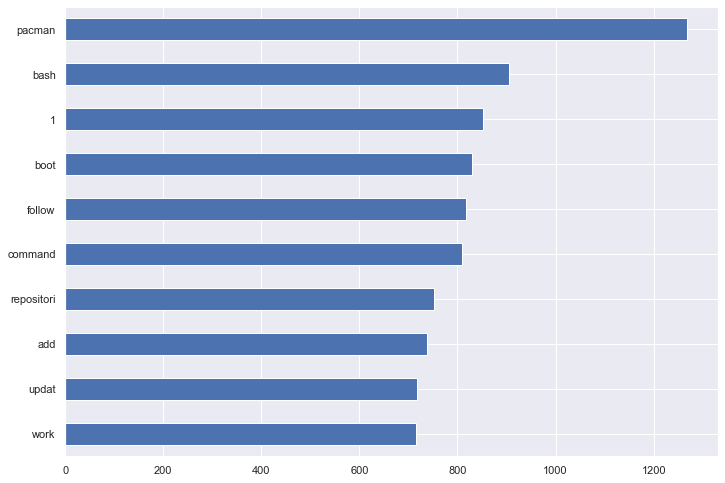

In [30]:
explore.arch_top_10(arch_corpus)

### Interesting Finds:

### Top 3 trigrams of Archlinux

In [31]:
explore.top_3_arch_trigrams(arch_corpus)

(sh, pacman, noconfirm)    85
(gnu, gener, public)       54
(gener, public, licen)     53
dtype: int64

### A snapshot of Debian 📸

In [32]:
df_debian = explore.debian_subset()

### Top 10 Debian words:

In [33]:
debian_corpus = explore.debian_corpus(df_debian)

In [67]:
debian_corpus.value_counts().nlargest(10)

AttributeError: 'list' object has no attribute 'value_counts'

## Distribution of unique words by language:

In [68]:
explore.debian_unique_words_by_lang(df_debian)

### A Snapshot of Ubuntu

In [36]:
#calling in df
ubuntu = explore.ubuntu_subset()

### Top 3 languages of Ubuntu:

In [38]:
explore.top_3_langs_ubuntu(ubuntu)

Shell         0.520747
Python        0.108921
Dockerfile    0.052905
Name: language, dtype: float64

### Stats about Ubuntu:

In [39]:
ubuntu_corpus = explore.ubuntu_corpus(ubuntu)

### Top 10 Bigrams of Ubuntu:

In [40]:
explore.ubuntu_top_10_bigrams(ubuntu_corpus)

(math, kernel)        322
(link, video)         322
(kernel, librari)     322
(neural, network)     310
(server, lt)          298
(librari, updat)      276
(tr, tr)              249
(gnulinux, server)    220
(environ, variabl)    194
(follow, command)     179
dtype: int64

### Word Cloud of Ubuntu Bigrams:

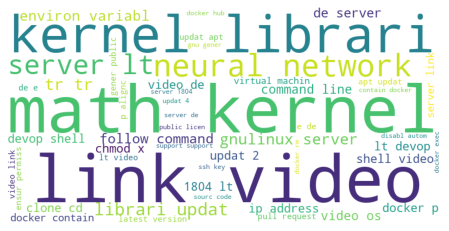

In [41]:
explore.ubuntu_top_50_bigram_wordcloud(ubuntu_corpus)

# Finding our answers:

Through the Exploration phase, we found some answers to some of our questions.
Such as, 

- 1) How many & what are the unique words to each specific programming language?<br>
<b>ANSWER: 

- 2) Are there any bigrams/trigrams that are specific to certain programming languages?<br>
<b>ANSWER:


- 3) Are there differences in words/phrases to Linux-flavors- specifically Ubuntu, Debian and Archlinux?<br>
<b>ANSWER:
<br>
<br>
Though we can prove these answers through our observations through Exploration, to have more validity to find if some of our hypothesis were correct, we needed to have further exploration through hypothesis testing.


# Hypothesis Testing

## Hypothesis 1
$H_{0}$ = Ubuntu distribution repos' readme files contain less than or equal text when comparing it to readme files for other distributions.<br><br>
$H_{a}$ = Ubuntu distribution repos' readme files contain more text than readme files for other distributions.

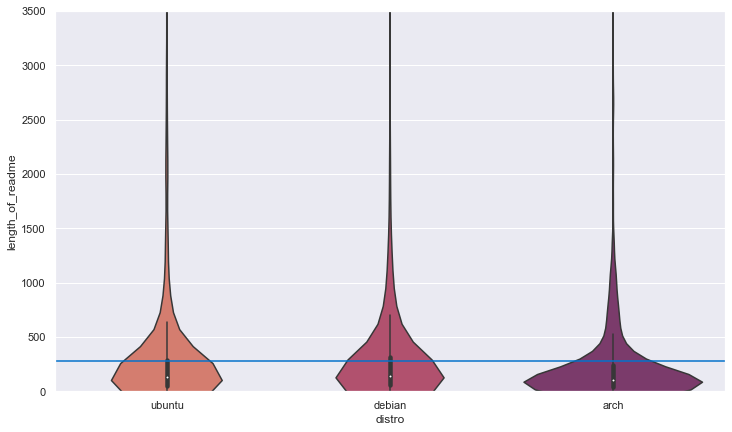

In [42]:
# Visualizing the shape and stat of the data from Hypothesis number 1 to be tested.
explore.hypothesis_1_viz_1(master_df)


In [43]:
alpha, ubuntu, debian, arch, non_ubuntu = explore.hypothesis_1_variables(master_df)

In [44]:
# Checking for variance with levene
stats.levene(ubuntu.length_of_readme, non_ubuntu.length_of_readme)
# Variance can be set to true

LeveneResult(statistic=2.6733936489633248, pvalue=0.1021505211008411)

In [45]:
# Performing t-test and printing out if the result is statistically significant and what the t value is.
t, p = stats.ttest_ind(ubuntu.length_of_readme, non_ubuntu.length_of_readme, equal_var=True)

(p/2) < alpha, t

(True, 1.733932100991937)

### Results:
<div class="alert alert-info">
Because p/2 is less than alpha and the t value is positive, I can reject the null hypothesis. Ubuntu distribution repos' readme files contain more text than readme files for other distributions.
</div>

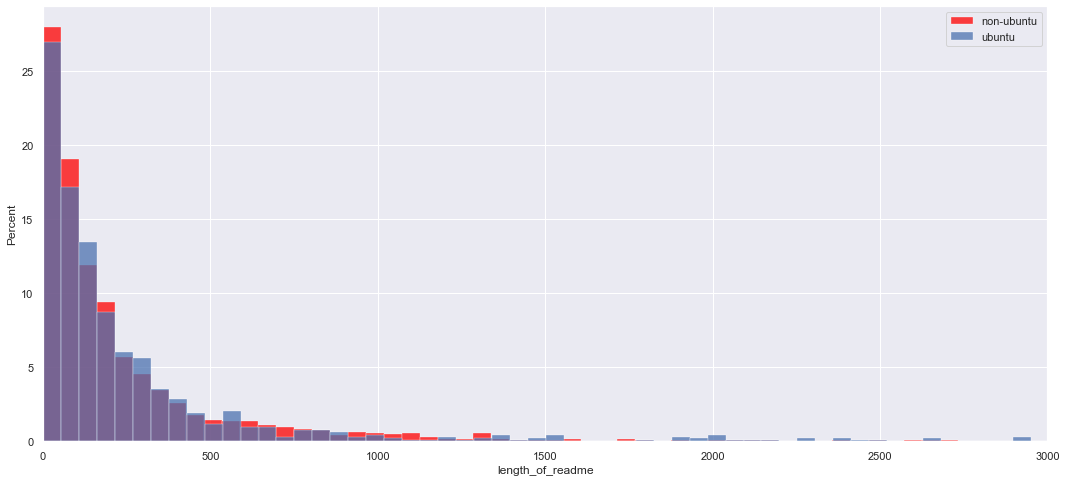

In [46]:
#Visualization of these results
explore.hypothesis_1_viz_2(non_ubuntu, ubuntu)

_____________________

## Hypothesis 2
$H_{0}$ =  Programming language is independent of linux distribution type.<br><br>
$H_{a}$ = Programming language is dependent of linux distribution type.

In [47]:
observed = explore.hypothesis_2_variables(arch, debian, ubuntu)

In [48]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

p

2.606671303060315e-13

In [49]:
p < alpha

True

### RESULTS:
<div class="alert alert-info">
We reject the null hypothesis. There is a statistically significant relationship between programming language and linux distribution.
</div>

#### Visualization of these relationships:

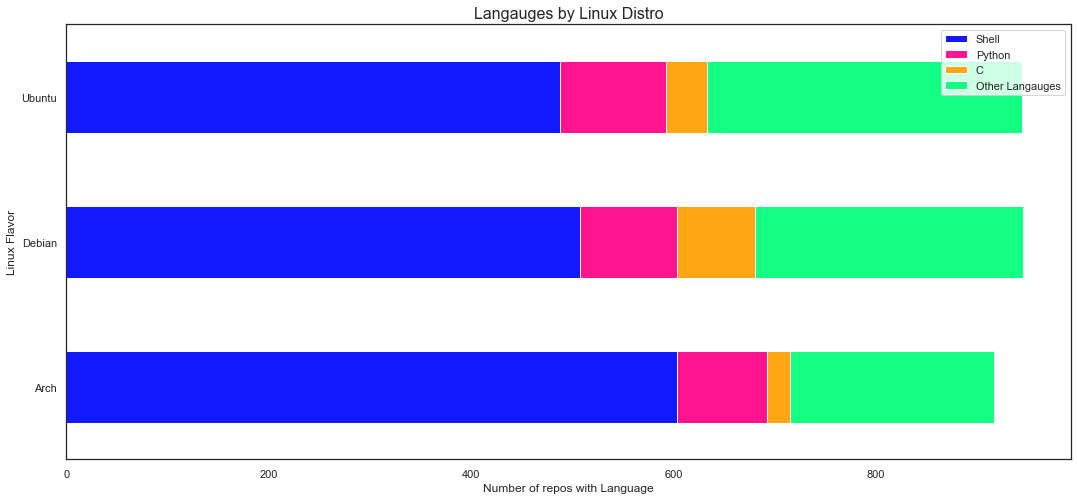

In [51]:
explore.hypothesis_2_viz(observed)

________________________________________

# Modeling Phase:

By exploring what would be the right model, Stephen FitzSimon created a Data Eater (MMM = Mass Model Maker) to run our
dataset through.

This MMM trains and validates our dataset through :<br>
- one Logistic Regression model<br>
- multiple Decision Tree Classifiers <br>
- multiple KNNeighbors <br>
- multiple Random Forest models

#### BASELINE:
Our baseline is the mode at which our top frequency language (Shell) is occuring in the dataset.<br>
<b>BASELINE ACCURACY = 0.52

In [59]:
#reading in the master_df
df_master = pd.read_csv('master_list.csv')

#splitting df through train, validate, and test
train, validate, test = m.make_model_dfs(df_master)

#fitting the train and validate onto data
models_df = m.model_maker(train, validate)

starting rf and et
finished rf and et


### Top 5 best predictive train/validate models:

In [60]:
models_df['change'] = models_df['train_accuracy'] - models_df['validate_accuracy']
models_df.sort_values(['validate_accuracy','better_than_baseline'], ascending=False).head(5)

,model,attributes,train_accuracy,validate_accuracy,better_than_baseline,change
124,BaggingClassifier,estimator = ExtraTreesClassifier,0.976695,0.896654,True,0.080041
123,BaggingClassifier,estimator = DecisionTreeClassifier,0.965042,0.891995,True,0.073047
1,KNNeighbors,n_neighbors = 1,0.989407,0.890301,True,0.099106
48,Decision Tree Classifier,max_depth = 24,0.921610,0.839898,True,0.081712
46,Decision Tree Classifier,max_depth = 23,0.917903,0.837357,True,0.080545


### Results/ Chosen Model:
<div class="alert alert-info">We decided on Ensemble Bagging Classifier model that uses a Decision Tree classifier as the estimator. Even though there was obvious overfitting happening, our validation accuracy came back well over baseline.</div>

# Testing the Model:

In [62]:
#calling in the test_model function to test the Ensemble Bagging Classifier
m.test_model(train, validate, test)

,model,attributes,train_accuracy,validate_accuracy,test_accuracy,better_than_baseline
0,BaggingClassifier,estimator = DecisionTreeClassifier,0.965042,0.891995,0.631512,True


## Takeaways & Model Results:

Even with the ensemble model, the model shows over-fitting.  This may be improved by experimenting with how the data is vectorized.

<b>Our Results came back to 63% of predictability</b> of programming languages based on README content. Our test data was used on unseen data.


_________________________________

# Next Steps:

Our next steps on the this project would be to continue to experiment with hyperparameters, such as finding other common words to include in stopwords to find unique occurences within the data acquired and to also pull more data for the model.